#  1.6 million (or is it???) UK traffic accidents 

### An exercise in discovering the obvious 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import functions as f

# Always make it pretty.
plt.style.use('ggplot')

In [2]:
# load data and find overall probability of an accident being in particular severity (mu)
df = f.load_and_clean_accident_data()
severity_mus = f.find_severity_mus(df)



/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
print(f'The actual number of accidents in this record, after removing duplicates is: {len(df)}')

The actual number of accidents in this record, after removing duplicates is: 1469963


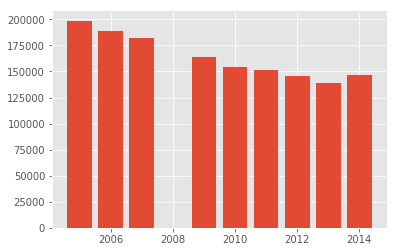

In [4]:
years = df.groupby(['Year']).count()['Accident_Index']
fig, ax = plt.subplots()
ax.bar(years.index, years.values)
None

### Finding the actual amounts of accidents by severity and correlate factor

In [5]:
df = f.cleaner_data(df)

#find actual amounts of each accident
actuals_severity_roadsc = np.transpose(np.reshape(df.groupby(['Accident_Severity','Road_Surface_Conditions']).count()['Accident_Index'].values,(3,3)))
actuals_severity_slimit = np.transpose(np.reshape(df.groupby(['Accident_Severity','Speed_limit']).count()['Accident_Index'].values,(3,7)))
actuals_severity_weather = np.transpose(np.reshape(df.groupby(['Accident_Severity','Weather_Conditions']).count()['Accident_Index'].values,(3,2)))

#total number of accidents within each category
roadsc_sums = df.groupby(['Road_Surface_Conditions']).count()['Accident_Index'].values
slimit_sums = df.groupby(['Speed_limit']).count()['Accident_Index'].values
weather_sums = df.groupby(['Weather_Conditions']).count()['Accident_Index'].values

In [6]:
#expected number of each severity under null hypothesis of varying category not having effect
expected_by_roadsc = np.dot(roadsc_sums.reshape((-1,1)),severity_mus.reshape((1,-1)))
expected_by_roadsc = expected_by_roadsc.round().astype(int)

expected_by_slimit = np.dot(slimit_sums.reshape((-1,1)),severity_mus.reshape((1,-1)))
expected_by_slimit = expected_by_slimit.round().astype(int)

expected_by_weather = np.dot(weather_sums.reshape((-1,1)),severity_mus.reshape((1,-1)))
expected_by_weather = expected_by_weather.round().astype(int)

### Proportion of accidents in each severity category by speed limit

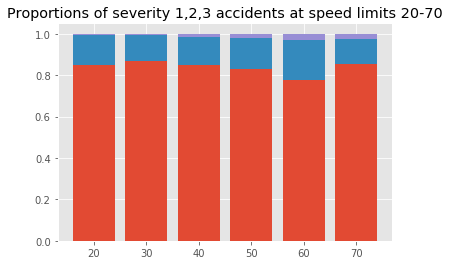

In [7]:
slimit20= df[df["Speed_limit"] == 20]
slimit30= df[df["Speed_limit"] == 30]
slimit40= df[df["Speed_limit"] == 40]
slimit50= df[df["Speed_limit"] == 50]
slimit60= df[df["Speed_limit"] == 60]
slimit70= df[df["Speed_limit"] == 70]

slimit_severities = np.vstack(((slimit20.Accident_Severity.value_counts(),
                              slimit30.Accident_Severity.value_counts(),
                              slimit40.Accident_Severity.value_counts(),
                              slimit50.Accident_Severity.value_counts(),
                              slimit60.Accident_Severity.value_counts(),
                              slimit70.Accident_Severity.value_counts(),)))

slimit_severities = slimit_severities / slimit_severities.sum(axis=1).reshape((6,-1))
slimit_severities

fig, ax = plt.subplots()
ax.bar(range(len(slimit_severities)), slimit_severities[:,0])
ax.bar(range(len(slimit_severities)), slimit_severities[:,1], bottom=slimit_severities[:,0])
ax.bar(range(len(slimit_severities)), slimit_severities[:,2], bottom=slimit_severities[:,0] + slimit_severities[:,1])

ax.set_xticks(np.arange(0,6))                                                                                                                
ax.set_xticklabels(np.arange(2,8)*10)
ax.set_title("Proportions of severity 1,2,3 accidents at speed limits 20-70")
None

### Hypothesis testing and results - (Discovering the obvious)

In [8]:
# calculating p values under null hypothesis of varying categories not having effect
p_values_roadsc = f.calculate_p_values(actuals_severity_roadsc,expected_by_roadsc)
p_values_slimit = f.calculate_p_values(actuals_severity_slimit,expected_by_slimit)
p_values_weather = f.calculate_p_values(actuals_severity_weather,expected_by_weather)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4567: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


In [9]:
print(f'p-value for dry roads: {p_values_roadsc[0]}',"\n",f'p-value for icy roads: {p_values_roadsc[1]}',"\n"
      ,f'p-value for wet roads: {p_values_roadsc[2]}',"\n\n")
print(f'p-value for 10mph speed limit: {p_values_slimit[0]}',"\n",
     f'p-value for 20mph speed limit: {p_values_slimit[1]}',"\n",
     f'p-value for 30mph speed limit: {p_values_slimit[2]}',"\n",
     f'p-value for 40mph speed limit: {p_values_slimit[3]}',"\n",
     f'p-value for 50mph speed limit: {p_values_slimit[4]}',"\n",
     f'p-value for 60mph speed limit: {p_values_slimit[5]}',"\n")
print(f'p-value for sunny weather: {p_values_weather[0]}',"\n",f'p-value for rainy weather: {p_values_weather[1]}')

p-value for dry roads: [1.9712979e-29] 
 p-value for icy roads: [3.89620787e-08] 
 p-value for wet roads: [7.01593117e-17] 


p-value for 10mph speed limit: [0.] 
 p-value for 20mph speed limit: [1.207247e-16] 
 p-value for 30mph speed limit: [0.] 
 p-value for 40mph speed limit: [8.63095953e-09] 
 p-value for 50mph speed limit: [3.57941245e-78] 
 p-value for 60mph speed limit: [0.] 

p-value for sunny weather: [1.67900061e-46] 
 p-value for rainy weather: [2.10436551e-99]


### Significant difference testing
#### (Or demonstration of all hypothesis tests rejecting with large enough sample size)

In [18]:
difference = .1

dangerous_severities = severity_mus.copy()
safer_severities = severity_mus.copy()
dangerous_severities[0] = severity_mus[0]*(1+difference)
safer_severities[0] = severity_mus[0]*(1-difference)
dangerous_severities[1] = severity_mus[1]*(1+difference)
safer_severities[1] = severity_mus[1]*(1-difference)
#After adding the difference, they must be normalized as ratios of each always sum to 1!
safer_severities = safer_severities / safer_severities.sum()
dangerous_severities = dangerous_severities / dangerous_severities.sum()

dangerous_severities - safer_severities

array([ 0.00220704,  0.02305606, -0.0252631 ])

In [19]:
safer_by_roadsc = np.dot(roadsc_sums.reshape((-1,1)),safer_severities.reshape((1,-1)))
safer_by_roadsc = safer_by_roadsc.round().astype(int)

dangerous_by_roadsc = np.dot(roadsc_sums.reshape((-1,1)),dangerous_severities.reshape((1,-1)))
dangerous_by_roadsc = dangerous_by_roadsc.round().astype(int)

safer_by_slimit = np.dot(slimit_sums.reshape((-1,1)),safer_severities.reshape((1,-1)))
safer_by_slimit = safer_by_slimit.round().astype(int)

dangerous_by_slimit = np.dot(slimit_sums.reshape((-1,1)),dangerous_severities.reshape((1,-1)))
dangerous_by_slimit = dangerous_by_slimit.round().astype(int)

safer_by_weather = np.dot(weather_sums.reshape((-1,1)),safer_severities.reshape((1,-1)))
safer_by_weather = safer_by_weather.round().astype(int)

dangerous_by_weather = np.dot(weather_sums.reshape((-1,1)),dangerous_severities.reshape((1,-1)))
dangerous_by_weather = dangerous_by_weather.round().astype(int)

In [24]:
s_p_values_roadsc = f.calculate_p_values(actuals_severity_roadsc,safer_by_roadsc)
s_p_values_slimit = f.calculate_p_values(actuals_severity_slimit,safer_by_slimit)
s_p_values_weather = f.calculate_p_values(actuals_severity_weather,safer_by_weather)
d_p_values_roadsc = f.calculate_p_values(actuals_severity_roadsc,dangerous_by_roadsc)
d_p_values_slimit = f.calculate_p_values(actuals_severity_slimit,dangerous_by_slimit)
d_p_values_weather = f.calculate_p_values(actuals_severity_weather,dangerous_by_weather)


print(s_p_values_roadsc[s_p_values_roadsc > .001])
print(s_p_values_slimit[s_p_values_slimit > .001])
print(s_p_values_weather[s_p_values_weather > .001])
print(d_p_values_roadsc[d_p_values_roadsc > .001])
print(d_p_values_slimit[d_p_values_slimit > .001])
print(d_p_values_weather[d_p_values_weather > .001])

print(s_p_values_roadsc)
# print(s_p_values_slimit)
# print(s_p_values_weather)
# print(d_p_values_roadsc)
# print(d_p_values_slimit)
# print(d_p_values_weather)



[0.65667151]
[]
[]
[]
[]
[]
[[0.00000000e+00]
 [6.56671512e-01]
 [2.06757660e-90]]


The exception that proves the rule: The smallest sample size group is the only one that had a significant p value